<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-задачи" data-toc-modified-id="Описание-задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание задачи</a></span><ul class="toc-item"><li><span><a href="#Цель-проекта" data-toc-modified-id="Цель-проекта-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Цель проекта</a></span></li><li><span><a href="#Область-применения-модели" data-toc-modified-id="Область-применения-модели-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Область применения модели</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

# Определение возраста покупателей

## Описание задачи

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

### Цель проекта 

Построить модель, которая по фотографии определит  возраст человека. 

### Область применения модели

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
- Контролировать добросовестность кассиров при продаже алкоголя

## Исследовательский анализ данных

Импортируем библиотеки

In [1]:
import pandas as pd

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [3]:
import matplotlib.pyplot as plt

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Выведем информацию

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Прочитаем фото

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Количество полученных батчей

In [8]:
len(train_gen_flow)

238

Получим из первого батча признаки и класса

In [9]:
X, y = next(train_gen_flow)

In [10]:
X.shape

(32, 224, 224, 3)

К-во в батче, размеры и цветовые каналы

In [11]:
y.shape

(32,)

Размер меток в батче также 32. Посмотрим на значения

In [12]:
y

array([50, 41, 46, 85, 14, 40, 14, 53,  4, 32, 14, 23, 37, 62, 21, 58, 43,
       32, 25, 94, 30, 16, 23, 18, 41, 24, 26, 14, 36, 28, 78, 13])

Значения разнообразные. Но нет отрицательных, что уже хорошо))

Распределение возраста

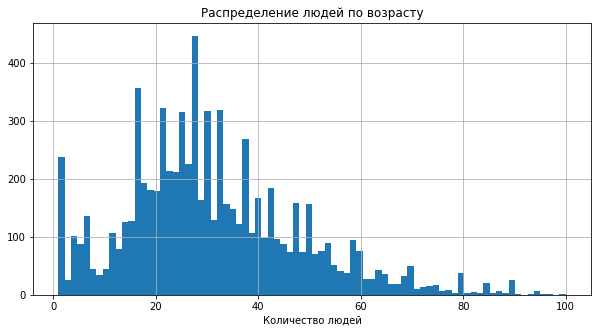

In [13]:
#labels.hist(bins=10, figsize =(10,5))
labels.hist(bins=80, figsize =(10,5))
plt.title('Распределение людей по возрасту')
plt.xlabel('Возраст')
plt.xlabel('Количество людей');

По графику видно, что преобладают люди со средним возрастом. Однако присутствуют и дети (возраст около нуля) и пожилые (возраст более 80).

Выведем 16 фото

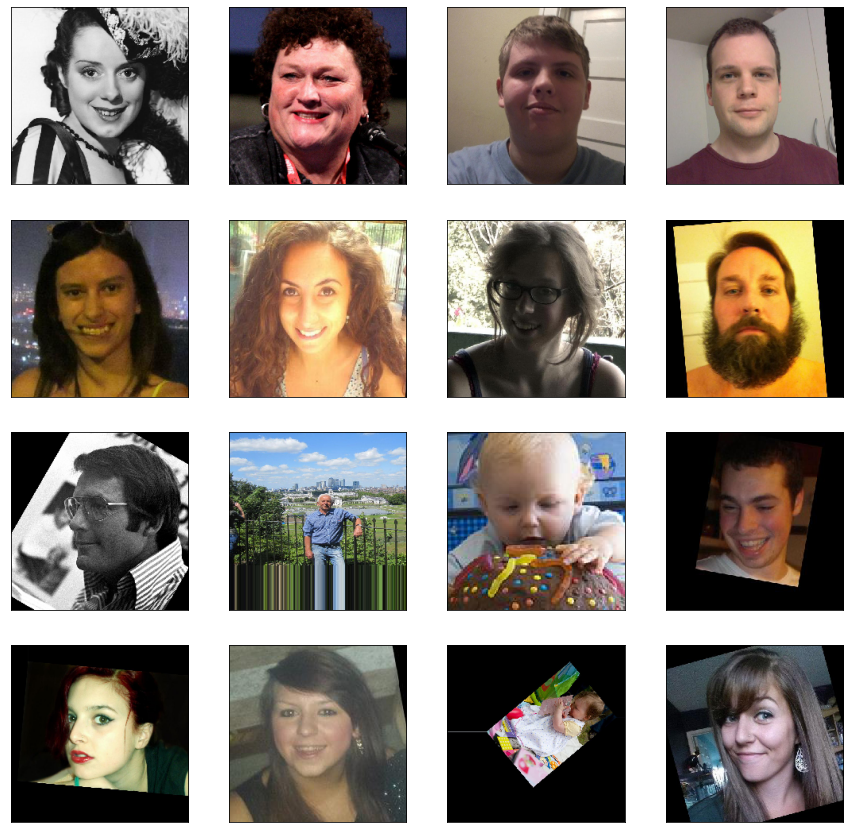

In [44]:
fig = plt.figure(figsize=(15,15))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(X[i])
    plt.xticks([])
    plt.yticks([])

Видим, что в выборке присутствуют взрослые и дети, разных полов. Фото могут быть повёрнутыми, цветными и черно-белыми.

## Обучение модели

```python

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np


def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/', 
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224), 
                                                     batch_size=16, 
                                                     class_mode='raw', 
                                                     subset='training',
                                                     seed=12345)
    return train_datagen_flow

def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/', 
                                                     x_col='file_name',
                                                     y_col='real_age', 
                                                     target_size=(224, 224), 
                                                     batch_size=16, 
                                                     class_mode='raw', 
                                                     subset='validation',
                                                     seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu')) 
    optimizer = Adam(lr=0.0001) 
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


def train_model(model,
                train_data, 
                test_data, 
                batch_size=None, 
                epochs=5,
                steps_per_epoch=None, 
                validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:   
        validation_steps=len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 139s - loss: 209.6340 - mae: 10.4614 - val_loss: 379.0085 - val_mae: 14.5058
Epoch 2/5
356/356 - 37s - loss: 69.5838 - mae: 6.3513 - val_loss: 116.0434 - val_mae: 8.1450
Epoch 3/5
356/356 - 38s - loss: 39.1705 - mae: 4.7885 - val_loss: 75.2696 - val_mae: 6.6114
Epoch 4/5
356/356 - 37s - loss: 23.4832 - mae: 3.7537 - val_loss: 71.8288 - val_mae: 6.3761
Epoch 5/5
356/356 - 37s - loss: 15.5136 - mae: 3.0480 - val_loss: 69.4854 - val_mae: 6.3010


119/119 - 9s - loss: 69.4854 - mae: 6.3010
Test MAE: 6.3010

```

## Анализ обученной модели

В качестве модели использовали ResNet50 c весами *imagenet*. Но выходе добавили 2 слоя - `GlobalAveragePooling2D` и `Dense` - слой с одним нейроном и функцией активации *relu*. Исходную выборку разбили на тренировочную и тестовую в соотношении 4:1.

В результате обучения модели получили метрику MAE 6.30 на тестовой выборке, что удовляетворяет требования задачи (MAE<8.0). Полученная метрика означает, что модель в среднем ошибается на 6,3 года в определении возраста. Для решения основых задач модель может быть использована, но с некоторыми оговорками. 

- **Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы**. 

Условие задачи подразумевает деление на возрастные группы. Какие это группы необходимо уточнить и возможно преобразовать модель для определения групп - решения задачи многоклассовой классификации. Возможно результат будет лучше.


- **Контролировать добросовестность кассиров при продаже алкоголя**. 

Продажа алкоголя в разных странах разрешается с разного возраста. Лучше бы уточнить возраст при постановке задачи. В текущем виде модель даёт достаточно большую ошибку в точности. Кроме того, задав пороговый возраст, задача возможно преобразовать в задачу бинарной классификации и оценить результат работы в этом случае.